In [1]:
%reload_kedro --env intel

                    INFO     Resolved project path as:                                              ]8;id=774530;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=423539;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/ipython/__init__.py#146\146]8;;\
                             /home/jamontanac/Documents/AdversarialExamples/adversarialexamples.                   
                             To set a different path, run '%reload_kedro <project_root>'                           

[05/04/24 17:07:39] INFO     Kedro project AdversarialExamples                                      ]8;id=702981;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=507384;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/ipython/__init__.py#115\115]8;;\

                    INFO     Defined global variable 'context', 'session', 'catalog' and            ]8;id=909732;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=353244;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/ipython/__init__.py#116\116]8;;\
                             'pipelines'                                                                           

                    INFO     Registered line magic 'run_viz'                                        ]8;id=43470;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/ipython/__init__.py\__init__.py]8;;\:]8;id=229792;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/ipython/__init__.py#122\122]8;;\

[05/04/24 17:10:36] INFO     Loading data from params:Data_information.input_shape              ]8;id=967311;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=216824;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (MemoryDataset)...                                                                    

[150, 150]

In [103]:
import torch
import itertools as it
import numpy as np
import matplotlib.pyplot as plt

#implement a 2d FFT for an image using pytorch
def randomFFT(image,log=True):
    """
    Apply 2D FFT to a given image.
    img: a tensor of shape (C, H, W)
    """
    # Convert the image to grayscale
    gray_image = torch.mean(image, dim=0, keepdim=True)
    
    # Apply 2D FFT to the grayscale image
    fft = torch.fft.fft2(gray_image, norm="ortho")
    fft = torch.fft.fftshift(fft)
    fft = torch.norm(fft,dim=0) 
    if log:
        fft = torch.log(fft + 1e-6)
    
    return fft

def plot_FFT(avg_diff,instance,size=(10,5),cmap = 'magma', title = '',magnitude = True):
    fig, ax = plt.subplots(1, 2, figsize=size)
    # Plot the average difference
    if magnitude:
        instance = torch.abs(instance)
    cbar1 = ax[0].imshow(20*avg_diff, cmap=cmap, interpolation='nearest')
    fig.colorbar(cbar1, ax=ax[0],shrink=0.7)
    ax[0].axis('off')
    ax[0].set_title(f"Average")

    # Plot the last adversarial_fft
    cbar2 = ax[1].imshow(instance, cmap=cmap, interpolation='nearest')
    # cbar2 = ax[1].imshow(instance, cmap=cmap, interpolation='nearest')
    fig.colorbar(cbar2, ax=ax[1],shrink=0.7)
    ax[1].axis('off')
    ax[1].set_title(f"Instance")

    fig.suptitle(title)
    fig.tight_layout()
    plt.show()

def compute_eigen_values(image,fft_image):
    """
    Compute the eigen values of the image and its attack.
    """
    # Convert the image to grayscale
    gray_image = torch.mean(image, dim=0, keepdim=True).squeeze()
    dimensions = gray_image.shape
    gray_image = gray_image@gray_image.T
    fft_image = fft_image@fft_image.T
    # adversarial_image_gray = torch.mean(adversarial_image, dim=0, keepdim=True).squeeze()
    # adversarial_image_gray = adversarial_image_gray@adversarial_image_gray.T
    # eigen_values_image,eigen_vectors_image = torch.linalg.eig(gray_image)
    # eigen_values_fft, eigen_vectors_fft = torch.linalg.eig(fft_image)
    eigen_values_image  = torch.linalg.eigvals(gray_image)
    # eigen_values_adv  = torch.linalg.eigvals(adversarial_image_gray)
    eigen_values_fft  = torch.linalg.eigvals(fft_image)


    return eigen_values_image/dimensions[1], eigen_values_fft/dimensions[1]
    # return eigen_values_image, eigen_values_adv


def generate_FFT_report(attacks,models,image_size,magnitude=True):
    for model, attack in it.product(models, attacks):
        adver = catalog.load(f'{model}_model_Adversarial_{attack}@Dataset')
        #get adversarial and original images
        original_images = adver['original']
        adversarial_images = adver['examples']
        average_difference = torch.zeros(*image_size)

        eigen_values_noise = torch.zeros(image_size[0]*len(original_images))
        eigen_values_noise_fft = torch.zeros(image_size[0]*len(original_images))
        eigen_values_image = torch.zeros(image_size[0]*len(original_images))
        eigen_values_image_fft = torch.zeros(image_size[0]*len(original_images))
        eigen_values_adv = torch.zeros(image_size[0]*len(original_images))
        eigen_values_adv_fft = torch.zeros(image_size[0]*len(original_images))
        eigen_values_log_diff = torch.zeros(image_size[0]*len(original_images))
        eigen_values_log_diff_fft = torch.zeros(image_size[0]*len(original_images))
        #iterate through the images and compute the FFT
        for i in range(len(original_images)): 
            original_image = original_images[i]
            adversarial_image = adversarial_images[i]
            noise_fft = randomFFT(adversarial_image-original_image,log=False)
            original_fft = randomFFT(original_image)
            adversarial_fft = randomFFT(adversarial_image)
            difference = torch.abs(adversarial_fft - original_fft)
            print(difference.shape,original_fft.shape,adversarial_fft.shape,noise_fft.shape)
            eig_image_noise, eig_fft_image_noise = compute_eigen_values(adversarial_image-original_image,noise_fft)
            eig_image, eig_fft_image = compute_eigen_values(original_image,
                                                            randomFFT(original_image,log=False))
            eig_adv, eig_fft_adv = compute_eigen_values(adversarial_image,
                                                        randomFFT(adversarial_image,log=False))
            eig_log_diff, eig_fft_log_diff = compute_eigen_values(
                torch.abs(torch.log(adversarial_image)-torch.log(original_image)),difference)
            eigen_values_noise[i*image_size[0]:(i+1)*image_size[0]] = torch.real(eig_image_noise)
            eigen_values_noise_fft[i*image_size[0]:(i+1)*image_size[0]] = torch.real(eig_fft_image_noise)
            eigen_values_image[i*image_size[0]:(i+1)*image_size[0]] = torch.real(eig_image)
            eigen_values_image_fft[i*image_size[0]:(i+1)*image_size[0]] = torch.real(eig_fft_image)
            eigen_values_adv[i*image_size[0]:(i+1)*image_size[0]] = torch.real(eig_adv)
            eigen_values_adv_fft[i*image_size[0]:(i+1)*image_size[0]] = torch.real(eig_fft_adv)
            eigen_values_log_diff[i*image_size[0]:(i+1)*image_size[0]] = torch.real(eig_log_diff)
            eigen_values_log_diff_fft[i*image_size[0]:(i+1)*image_size[0]] = torch.real(eig_fft_log_diff)
            average_difference += difference
            
        average_difference /= len(original_images)
        eigen_info = {
            'eigen_values_noise': eigen_values_noise,
            'eigen_values_noise_fft': eigen_values_noise_fft,
            'eigen_values_image': eigen_values_image,
            'eigen_values_image_fft': eigen_values_image_fft,
            'eigen_values_adv': eigen_values_adv,
            'eigen_values_adv_fft': eigen_values_adv_fft,
            'eigen_values_log_diff': eigen_values_log_diff,
            'eigen_values_log_diff_fft': eigen_values_log_diff_fft
        }
        plot_FFT(average_difference,adversarial_fft,title=f"{model} model with {attack} attack",magnitude = magnitude)
        yield average_difference, eigen_info


attacks = ["DeepFool", "CarliniL2", "FSGM", "PGD"]
models = ['Resnet','Regnet_x','Regnet_y']
image_size = catalog.load("params:Data_information.input_shape")
result = next(generate_FFT_report(attacks,models,image_size,magnitude=False))

[05/04/24 22:55:40] INFO     Loading data from params:Data_information.input_shape              ]8;id=313571;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=270719;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (MemoryDataset)...                                                                    

                    INFO     Loading data from Resnet_model_Adversarial_DeepFool@Dataset        ]8;id=197239;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=111472;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (PytorchDatasetDict)...                                                               

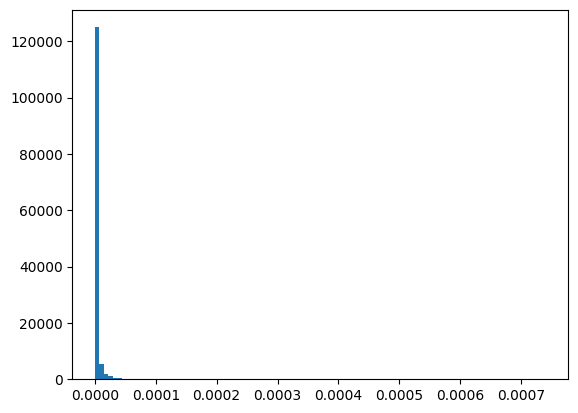

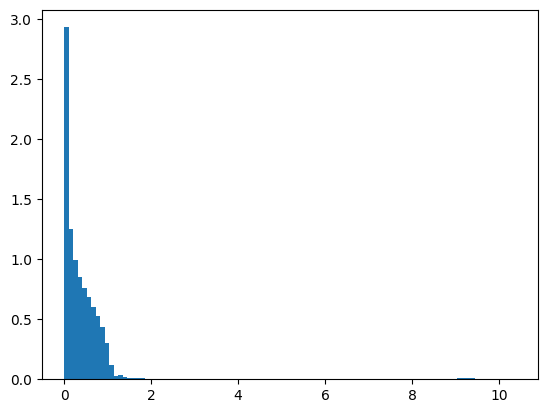

In [96]:
plt.hist(torch.log(result[1]+1),bins=100,density=True)
plt.show()
plt.hist(torch.log(result[2]+1),bins=100,density=True)
plt.show()

In [73]:
torch.mean(original_image, dim=0, keepdim=True).squeeze().shape

torch.Size([150, 150])

[05/04/24 19:49:17] INFO     Loading data from Resnet_model_Adversarial_DeepFool@Dataset        ]8;id=738462;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=681827;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (PytorchDatasetDict)...                                                               

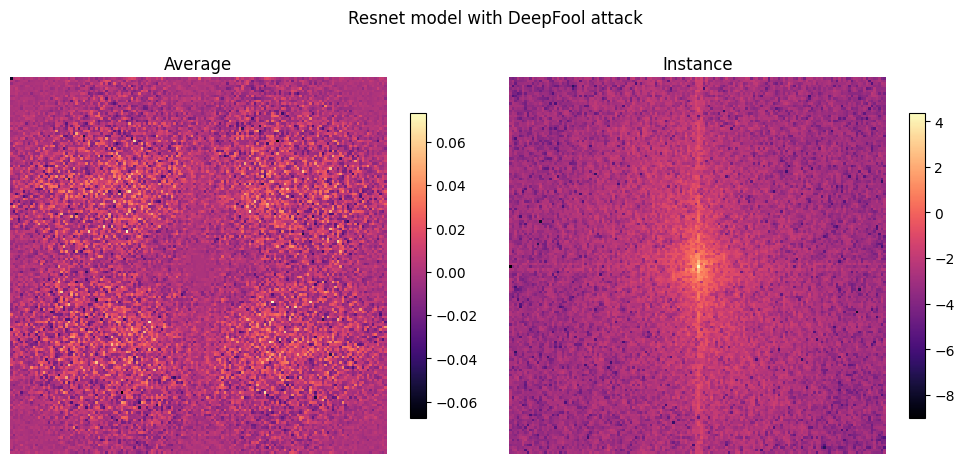

In [64]:

generate_FFT_report(attacks,models,image_size,magnitude=False) 

[05/04/24 19:43:54] INFO     Loading data from params:Report_params.Classes_names               ]8;id=901259;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=452693;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (MemoryDataset)...                                                                    

                    INFO     Loading data from params:Data_information.input_shape              ]8;id=724602;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=8697;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (MemoryDataset)...                                                                    

                    INFO     Loading data from Resnet_model_Adversarial_DeepFool@Dataset        ]8;id=434024;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=983530;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (PytorchDatasetDict)...                                                               

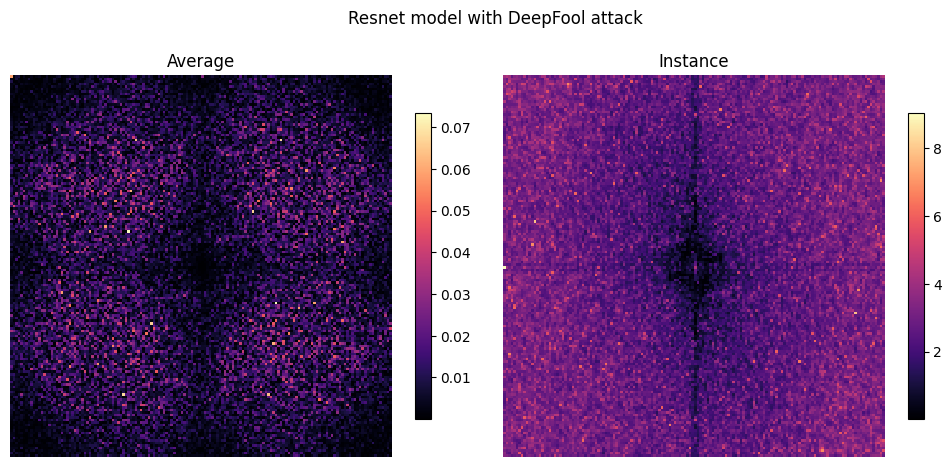

[05/04/24 19:44:06] INFO     Loading data from Resnet_model_Adversarial_CarliniL2@Dataset       ]8;id=143368;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=925728;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (PytorchDatasetDict)...                                                               

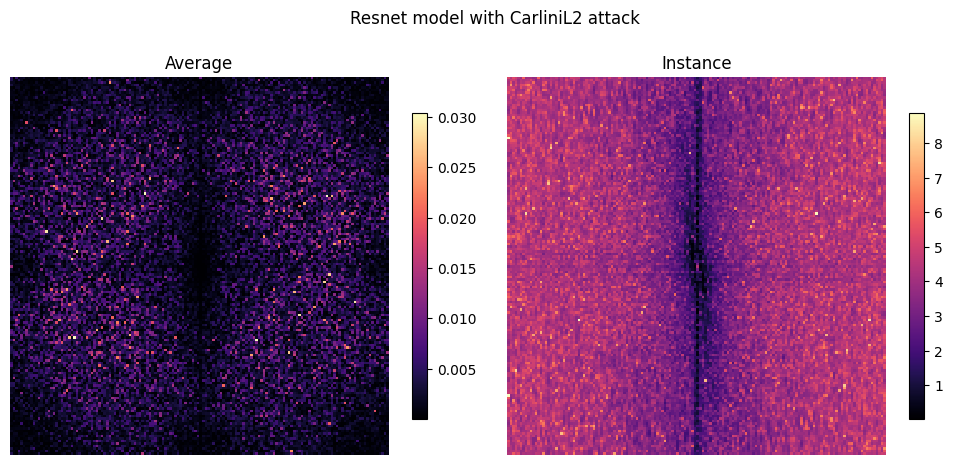

[05/04/24 19:44:18] INFO     Loading data from Resnet_model_Adversarial_FSGM@Dataset            ]8;id=388626;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=55655;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (PytorchDatasetDict)...                                                               

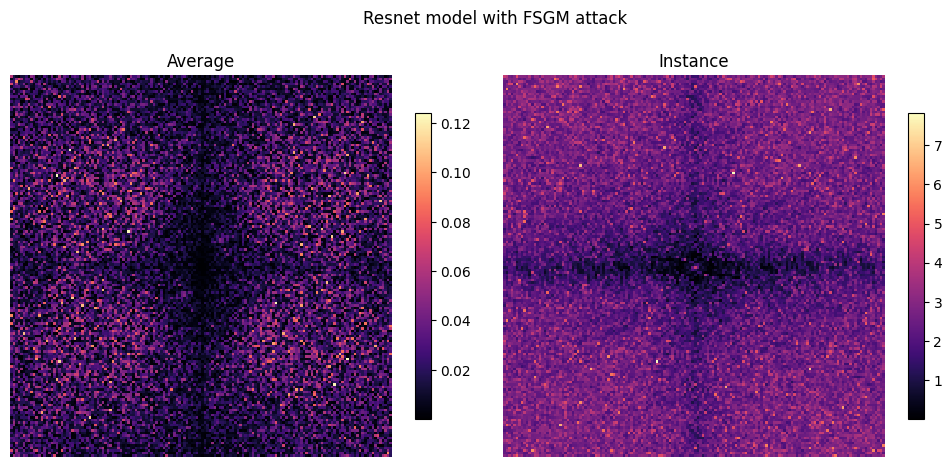

[05/04/24 19:44:31] INFO     Loading data from Resnet_model_Adversarial_PGD@Dataset             ]8;id=137918;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=233852;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (PytorchDatasetDict)...                                                               

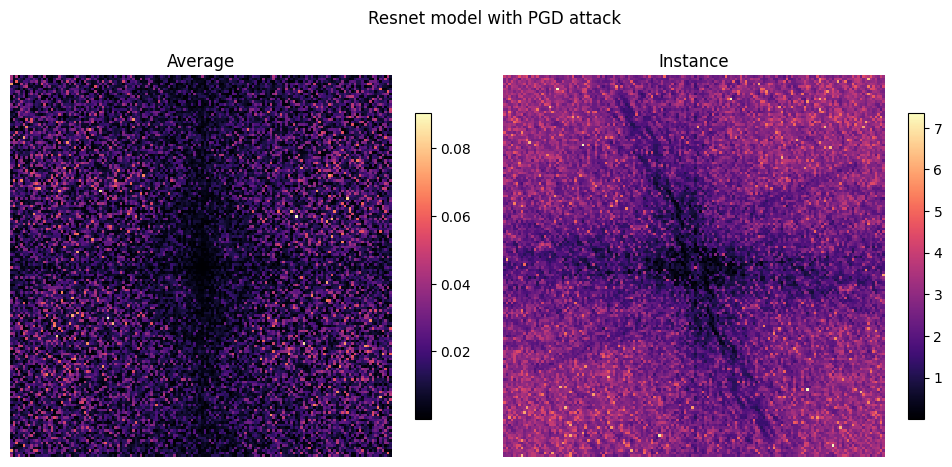

[05/04/24 19:44:40] INFO     Loading data from Regnet_x_model_Adversarial_DeepFool@Dataset      ]8;id=893520;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=36992;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (PytorchDatasetDict)...                                                               

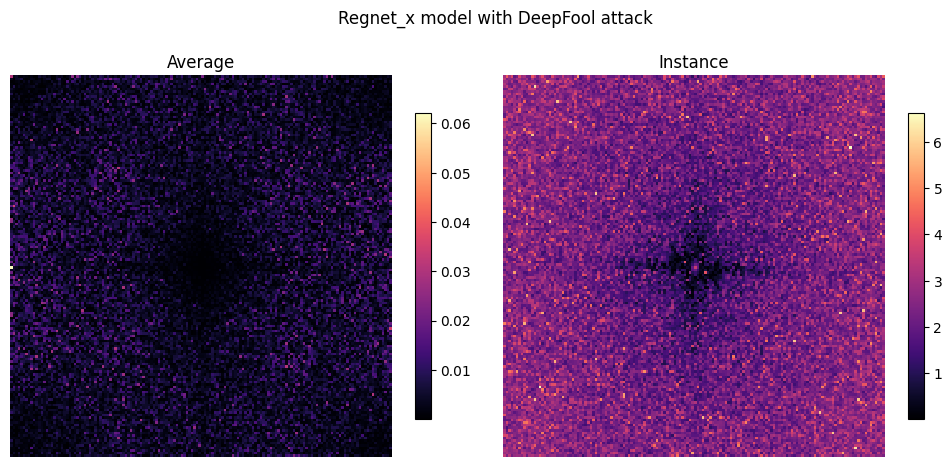

[05/04/24 19:44:50] INFO     Loading data from Regnet_x_model_Adversarial_CarliniL2@Dataset     ]8;id=189947;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=335107;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (PytorchDatasetDict)...                                                               

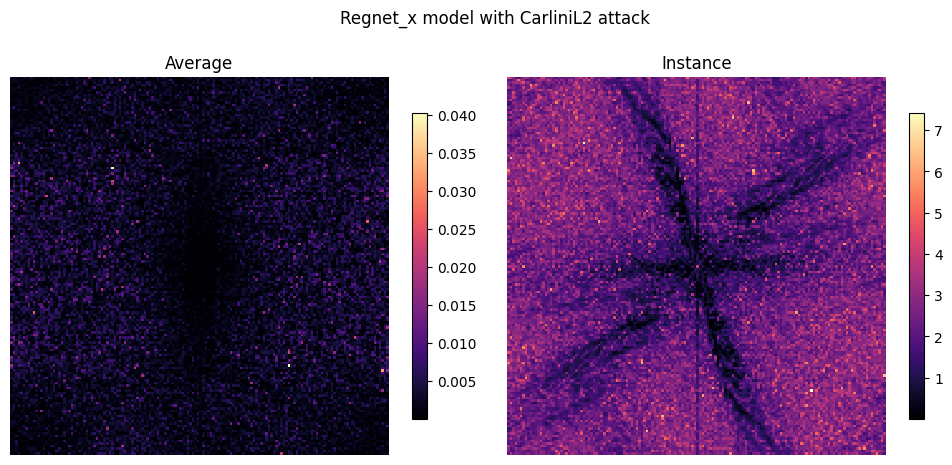

[05/04/24 19:44:59] INFO     Loading data from Regnet_x_model_Adversarial_FSGM@Dataset          ]8;id=891532;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=792117;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (PytorchDatasetDict)...                                                               

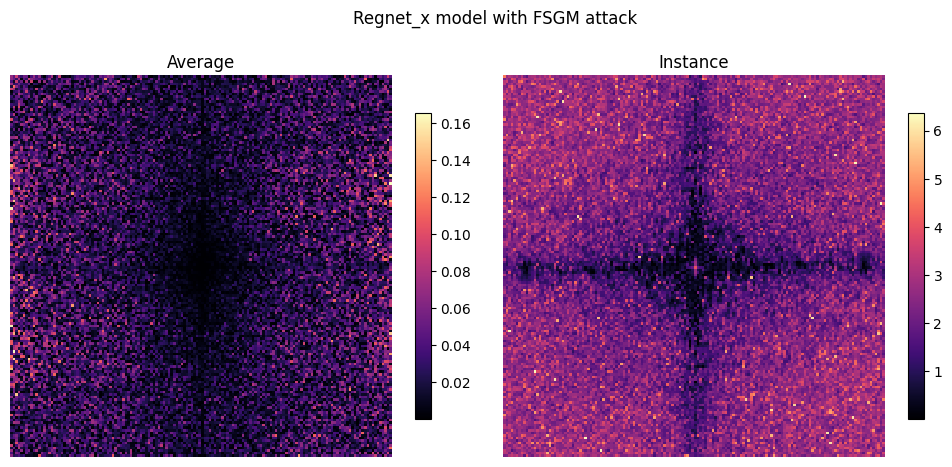

[05/04/24 19:45:10] INFO     Loading data from Regnet_x_model_Adversarial_PGD@Dataset           ]8;id=496076;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=617028;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (PytorchDatasetDict)...                                                               

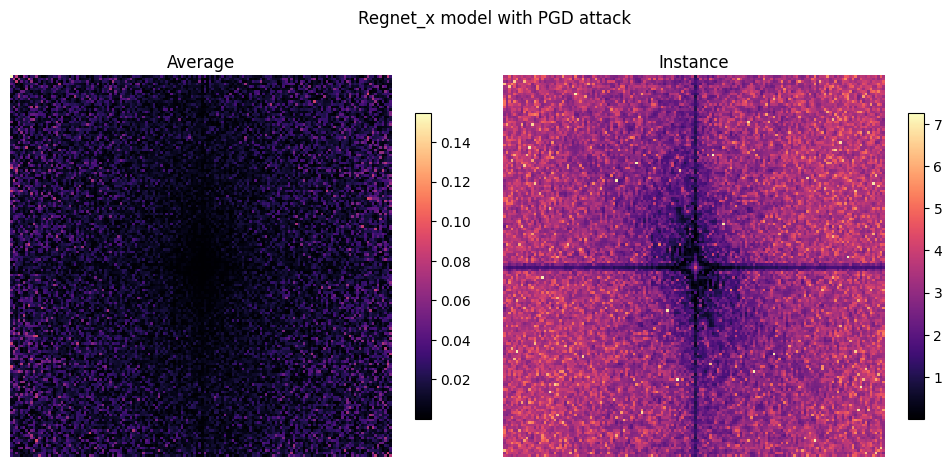

[05/04/24 19:45:20] INFO     Loading data from Regnet_y_model_Adversarial_DeepFool@Dataset      ]8;id=940636;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=948722;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (PytorchDatasetDict)...                                                               

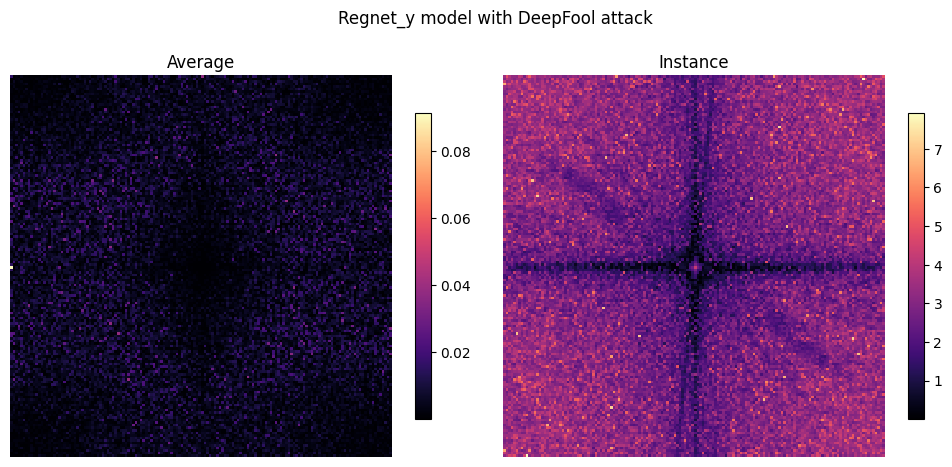

[05/04/24 19:45:29] INFO     Loading data from Regnet_y_model_Adversarial_CarliniL2@Dataset     ]8;id=864328;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=535660;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (PytorchDatasetDict)...                                                               

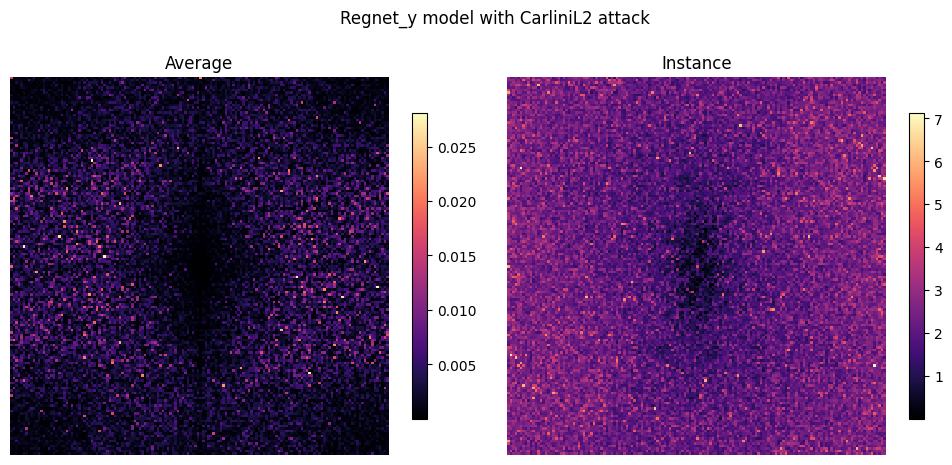

[05/04/24 19:45:39] INFO     Loading data from Regnet_y_model_Adversarial_FSGM@Dataset          ]8;id=243715;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=701481;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (PytorchDatasetDict)...                                                               

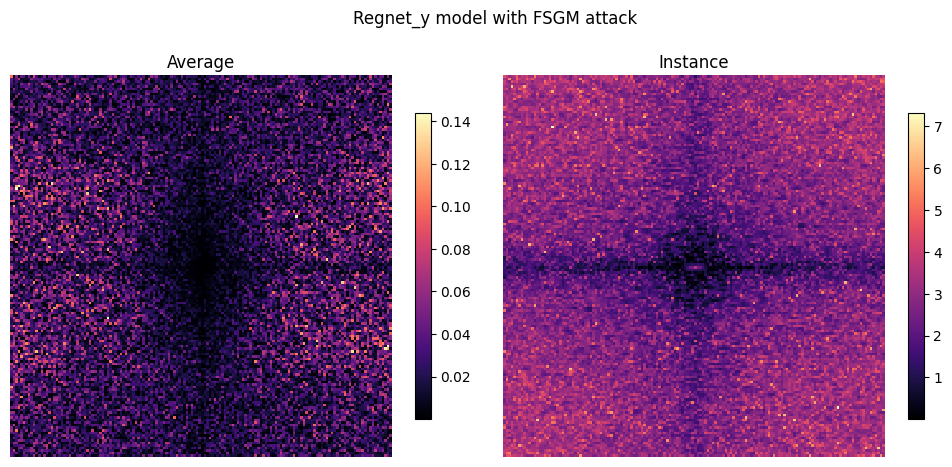

[05/04/24 19:45:48] INFO     Loading data from Regnet_y_model_Adversarial_PGD@Dataset           ]8;id=448308;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py\data_catalog.py]8;;\:]8;id=958058;file:///home/jamontanac/miniconda3/envs/AdvExamples/lib/python3.10/site-packages/kedro/io/data_catalog.py#482\482]8;;\
                             (PytorchDatasetDict)...                                                               

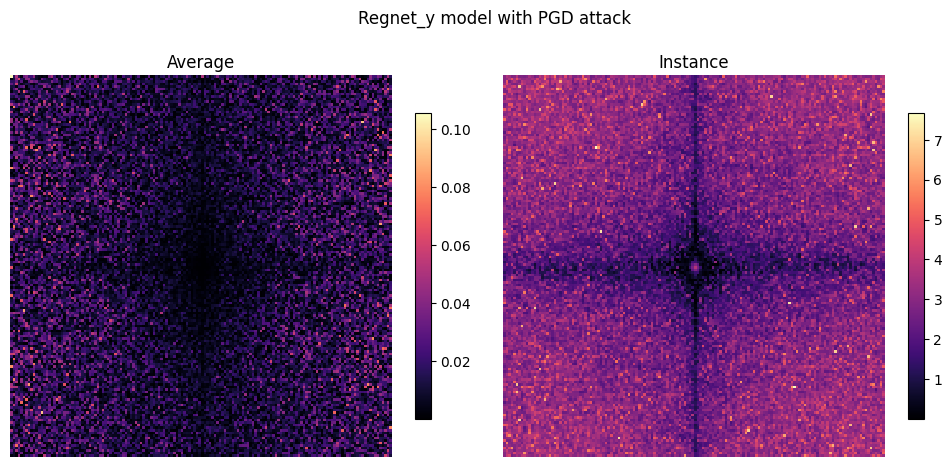

In [61]:

attacks = ["DeepFool", "CarliniL2", "FSGM", "PGD"]
# attacks = ["PGD"]
models = ['Resnet','Regnet_x','Regnet_y']
# models = ['Resnet',]
classes  = catalog.load('params:Report_params.Classes_names')
image_size = catalog.load("params:Data_information.input_shape")
for model, attack in it.product(models, attacks):
    adver = catalog.load(f'{model}_model_Adversarial_{attack}@Dataset')
    #get adversarial and original images
    original_images = adver['original']
    adversarial_images = adver['examples']
    average_difference = torch.zeros(*image_size)
    #iterate through the images and compute the FFT
    for i in range(len(original_images)):
        original_image = original_images[i]
        adversarial_image = adversarial_images[i]
        original_fft = randomFFT(original_image)
        adversarial_fft = randomFFT(adversarial_image)
        difference = adversarial_fft - original_fft
        average_difference += difference
    average_difference /= len(original_images)
    
    plot_FFT(average_difference,adversarial_fft,title=f"{model} model with {attack} attack")


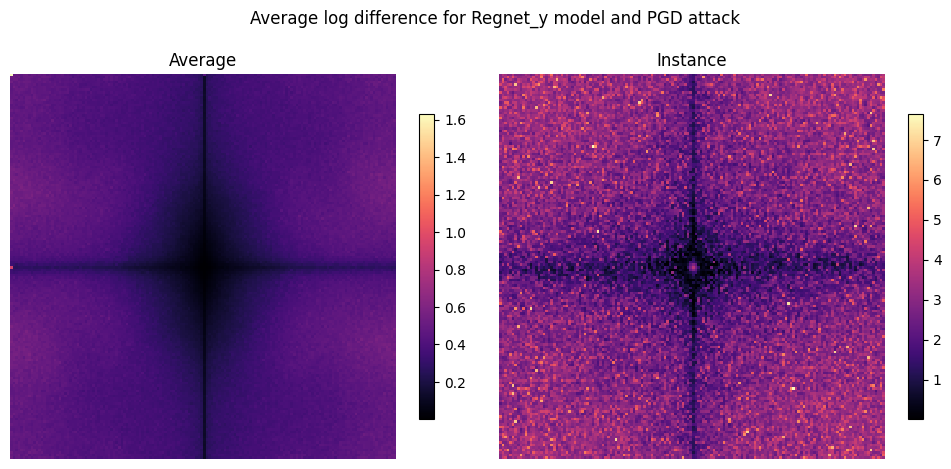

In [56]:
# Plot the result
def plot_FFT(avg_diff,instance,size=(10,5),cmap = 'magma', title = ''):
    fig, ax = plt.subplots(1, 2, figsize=size)
    # Plot the average difference
    cbar1 = ax[0].imshow(20*avg_diff, cmap=cmap, interpolation='nearest')
    fig.colorbar(cbar1, ax=ax[0],shrink=0.7)
    ax[0].axis('off')
    ax[0].set_title(f"Average")

    # Plot the last adversarial_fft
    cbar2 = ax[1].imshow(torch.abs(instance), cmap=cmap, interpolation='nearest')
    fig.colorbar(cbar2, ax=ax[1],shrink=0.7)
    ax[1].axis('off')
    ax[1].set_title(f"Instance")

    fig.suptitle(title)
    # plt.subplots_adjust(hspace=0.9)  # Adjust the spacing between subplots
    fig.tight_layout()
    plt.show()
plot_FFT(average_difference,adversarial_fft,title = f"Average log difference for {model} model and {attack} attack",cmap='magma')

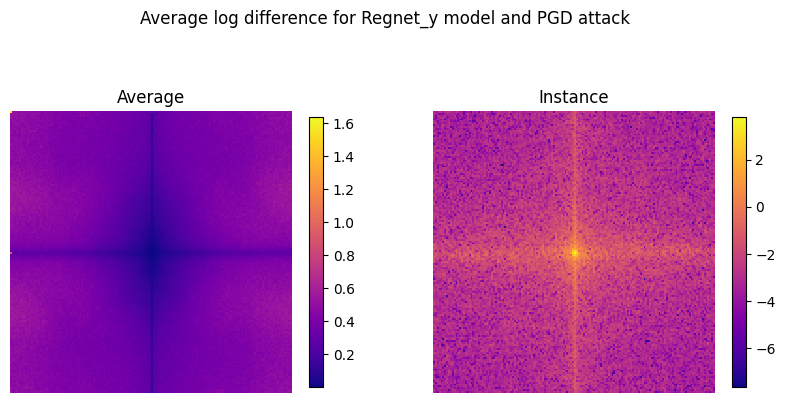

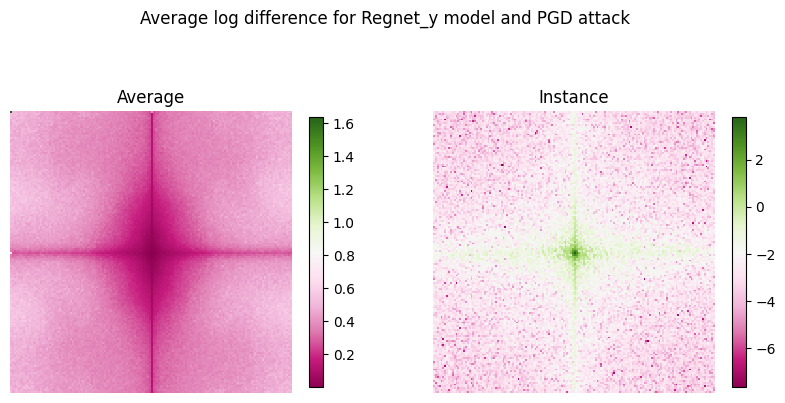

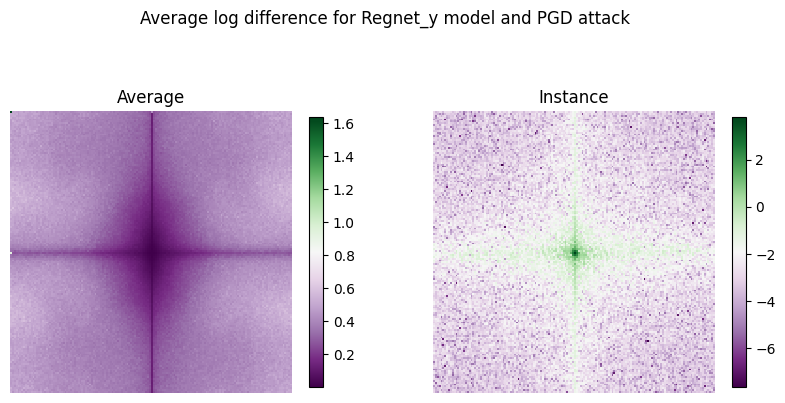

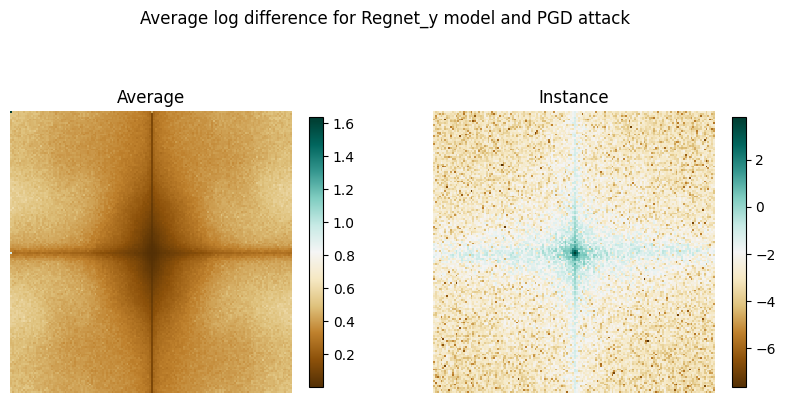

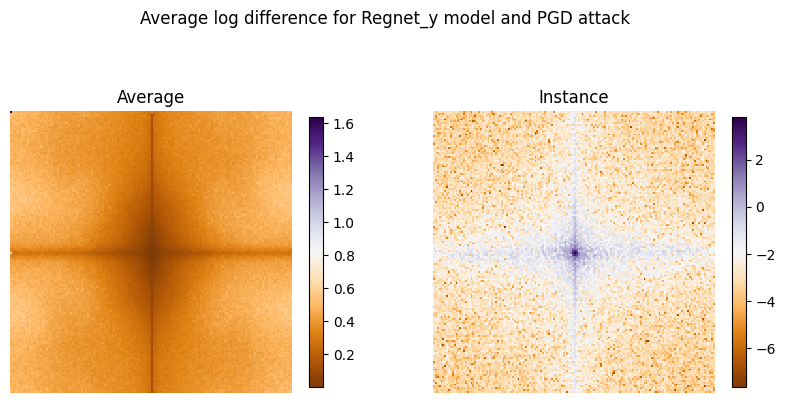

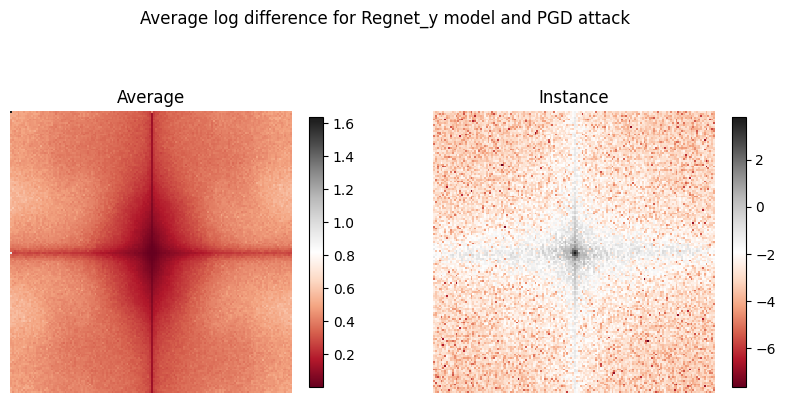

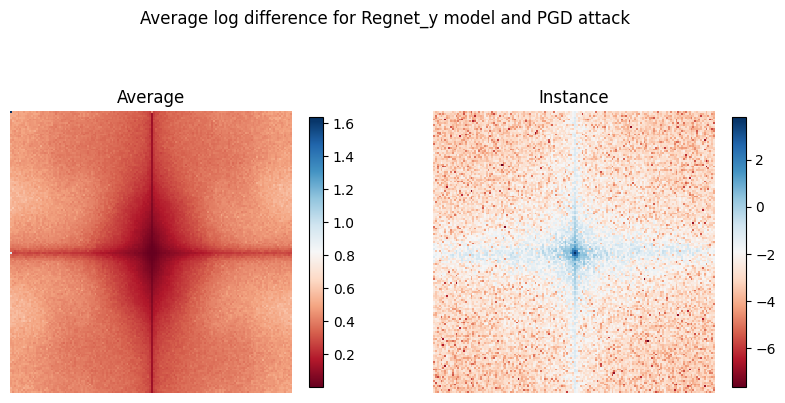

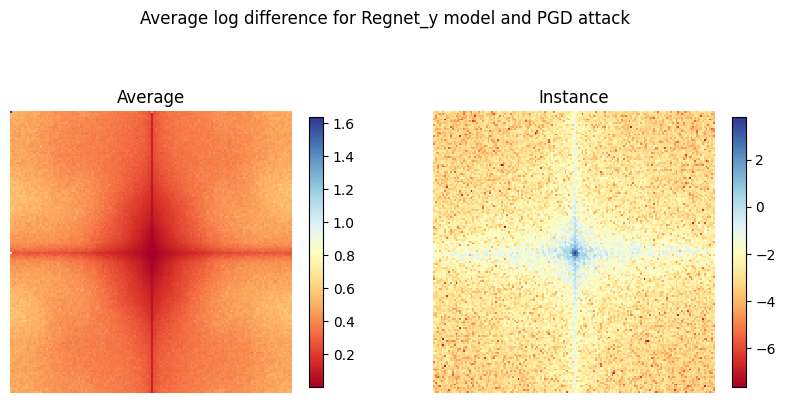

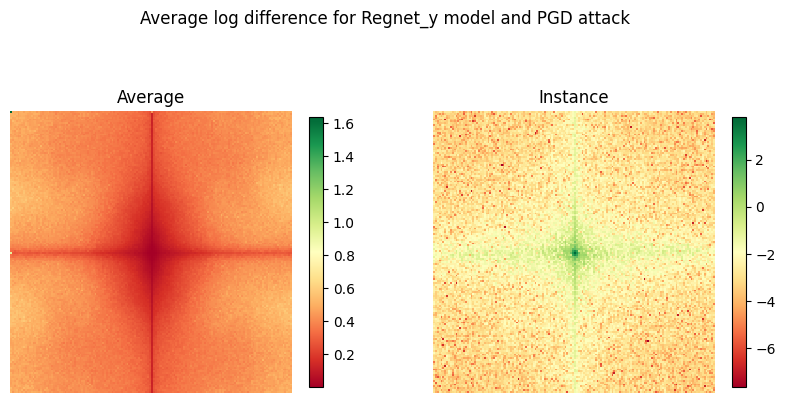

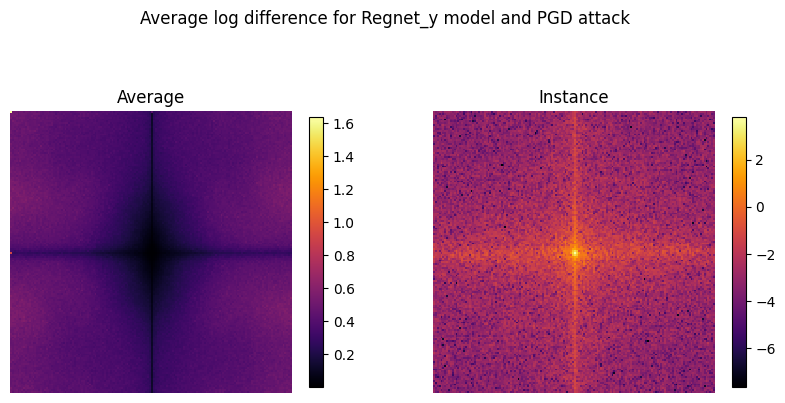

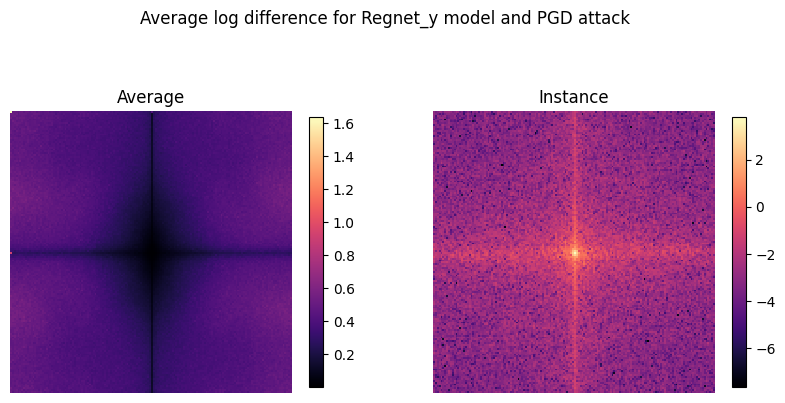

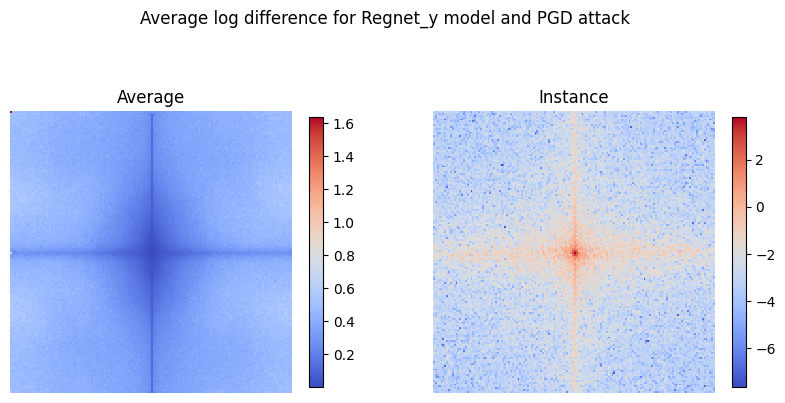

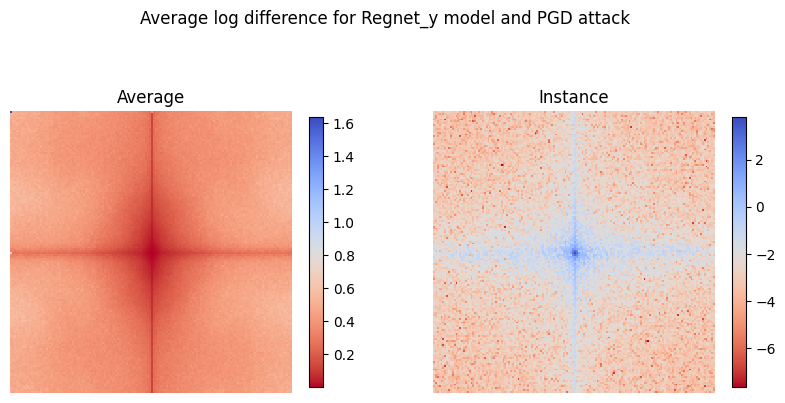

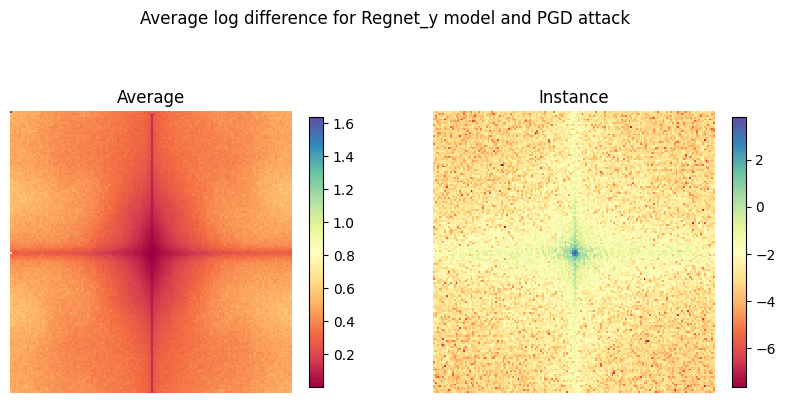

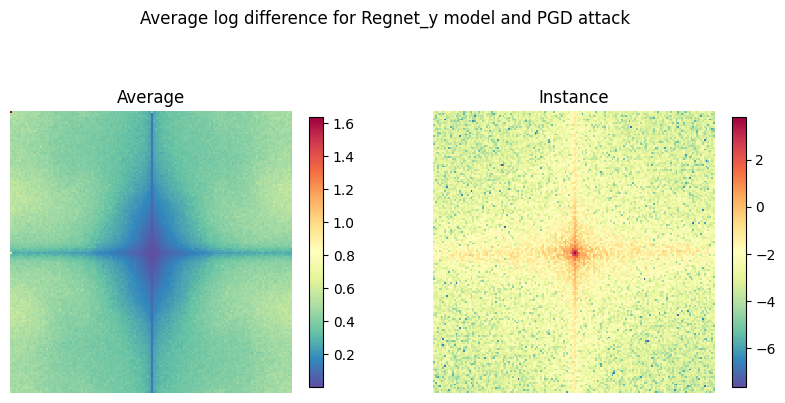

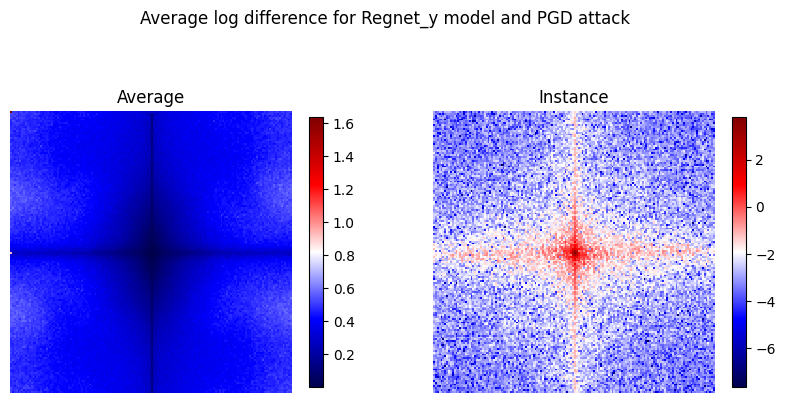

In [ ]:

# plot_FFT(average_difference,adversarial_fft,title = f"Average log difference for {model} model and {attack} attack", cmap='plasma')
# plot_FFT(average_difference,adversarial_fft,title = f"Average log difference for {model} model and {attack} attack", cmap='PiYG')
# plot_FFT(average_difference,adversarial_fft,title = f"Average log difference for {model} model and {attack} attack", cmap='PRGn')
# plot_FFT(average_difference,adversarial_fft,title = f"Average log difference for {model} model and {attack} attack", cmap='BrBG')
# plot_FFT(average_difference,adversarial_fft,title = f"Average log difference for {model} model and {attack} attack", cmap='PuOr')
# plot_FFT(average_difference,adversarial_fft,title = f"Average log difference for {model} model and {attack} attack", cmap='RdGy')
# plot_FFT(average_difference,adversarial_fft,title = f"Average log difference for {model} model and {attack} attack", cmap='RdBu')
# plot_FFT(average_difference,adversarial_fft,title = f"Average log difference for {model} model and {attack} attack", cmap='RdYlBu')
# plot_FFT(average_difference,adversarial_fft,title = f"Average log difference for {model} model and {attack} attack", cmap='RdYlGn')
# plot_FFT(average_difference,adversarial_fft,title = f"Average log difference for {model} model and {attack} attack", cmap='inferno')
# plot_FFT(average_difference,adversarial_fft,title = f"Average log difference for {model} model and {attack} attack", cmap='magma')
# plot_FFT(average_difference,adversarial_fft,title = f"Average log difference for {model} model and {attack} attack", cmap='coolwarm')
# plot_FFT(average_difference,adversarial_fft,title = f"Average log difference for {model} model and {attack} attack", cmap='coolwarm_r')
# plot_FFT(average_difference,adversarial_fft,title = f"Average log difference for {model} model and {attack} attack", cmap='Spectral')
# plot_FFT(average_difference,adversarial_fft,title = f"Average log difference for {model} model and {attack} attack", cmap='Spectral_r')
# plot_FFT(average_difference,adversarial_fft,title = f"Average log difference for {model} model and {attack} attack", cmap='seismic')

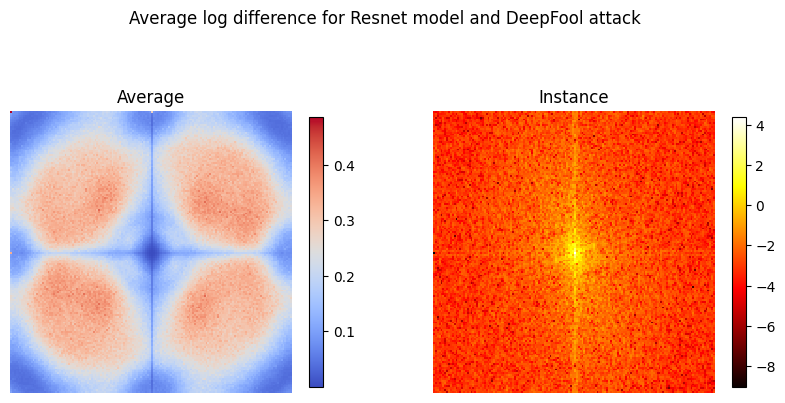

In [40]:

# Plot the result
def plot_FFT(avg_diff,instance,size=(10,5),cmap = 'hot', title = ''):
    fig, ax = plt.subplots(1, 2, figsize=size)
    # Plot the average difference
    cbar1 = ax[0].imshow(20*avg_diff, cmap=cmap, interpolation='nearest')
    fig.colorbar(cbar1, ax=ax[0],shrink=0.7)
    ax[0].axis('off')
    ax[0].set_title(f"Average")

    # Plot the last adversarial_fft
    cbar2 = ax[1].imshow(instance, cmap=cmap, interpolation='nearest')
    fig.colorbar(cbar2, ax=ax[1],shrink=0.7)
    ax[1].axis('off')
    ax[1].set_title(f"Instance")

    fig.suptitle(title)
    plt.show()
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Plot the average difference
cbar1 = ax[0].imshow(20*average_difference, cmap='coolwarm', interpolation='nearest')
fig.colorbar(cbar1, ax=ax[0],shrink=0.7)
ax[0].axis('off')
ax[0].set_title(f"Average")

# Plot the last adversarial_fft
cbar2 = ax[1].imshow(adversarial_fft, cmap='hot', interpolation='nearest')
fig.colorbar(cbar2, ax=ax[1],shrink=0.7)
ax[1].axis('off')
ax[1].set_title(f"Instance")

fig.suptitle(f"Average log difference for {model} model and {attack} attack")
plt.show()

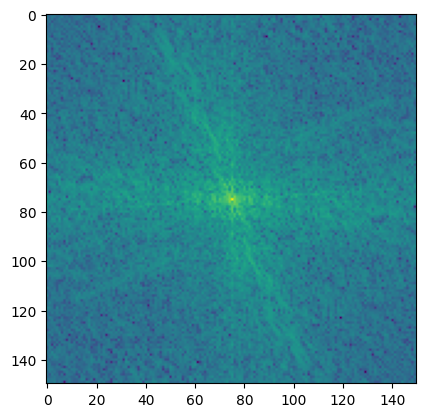

In [19]:
plt.imshow(adversarial_fft)

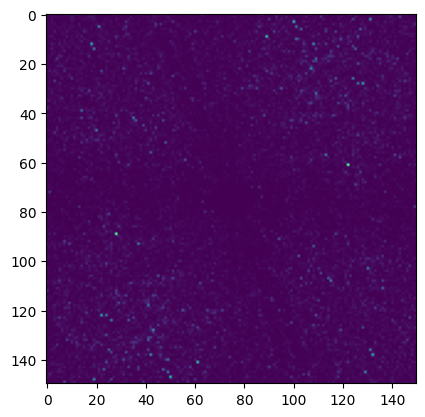

In [23]:
plt.imshow(torch.abs(original_fft- adversarial_fft))